In [1]:
### Load libraries ###

# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.stattools import adfuller

from sklearn.neural_network import MLPRegressor
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Machine Learning libraries
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn import set_config
set_config(display='diagram')
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})


# MLTOOLS - Custom library
from mltools import regression_tools as RT
from mltools import forecast_tools as FT
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns
import scipy as sp

# Statsmodels time series 
#from statsmodels.tsa import SARIMAX
import statsmodels.api as sm

# Datetime for managing dates
from datetime import datetime
import scipy.stats as st

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch installation could not be found, only numpy activation functions allowed


---
## 1. Read the dataset

Indicamos que la variable date tiene fechas (parse_dates), para decirle que no es una variable mas sino que es un indice de fechas. 

Al leer el df, no lo configuramos como una variable más sino como un indice. 

In [114]:
# Import data
dateparse = lambda x :datetime.strptime(x ,"%d/%m/%Y")

df = pd.read_csv('UnemploymentSpain.dat',sep='\t', parse_dates=['DATE'], dayfirst=True, date_parser=dateparse, index_col='DATE')

df.head()

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285


In [115]:
df.shape

(262, 1)

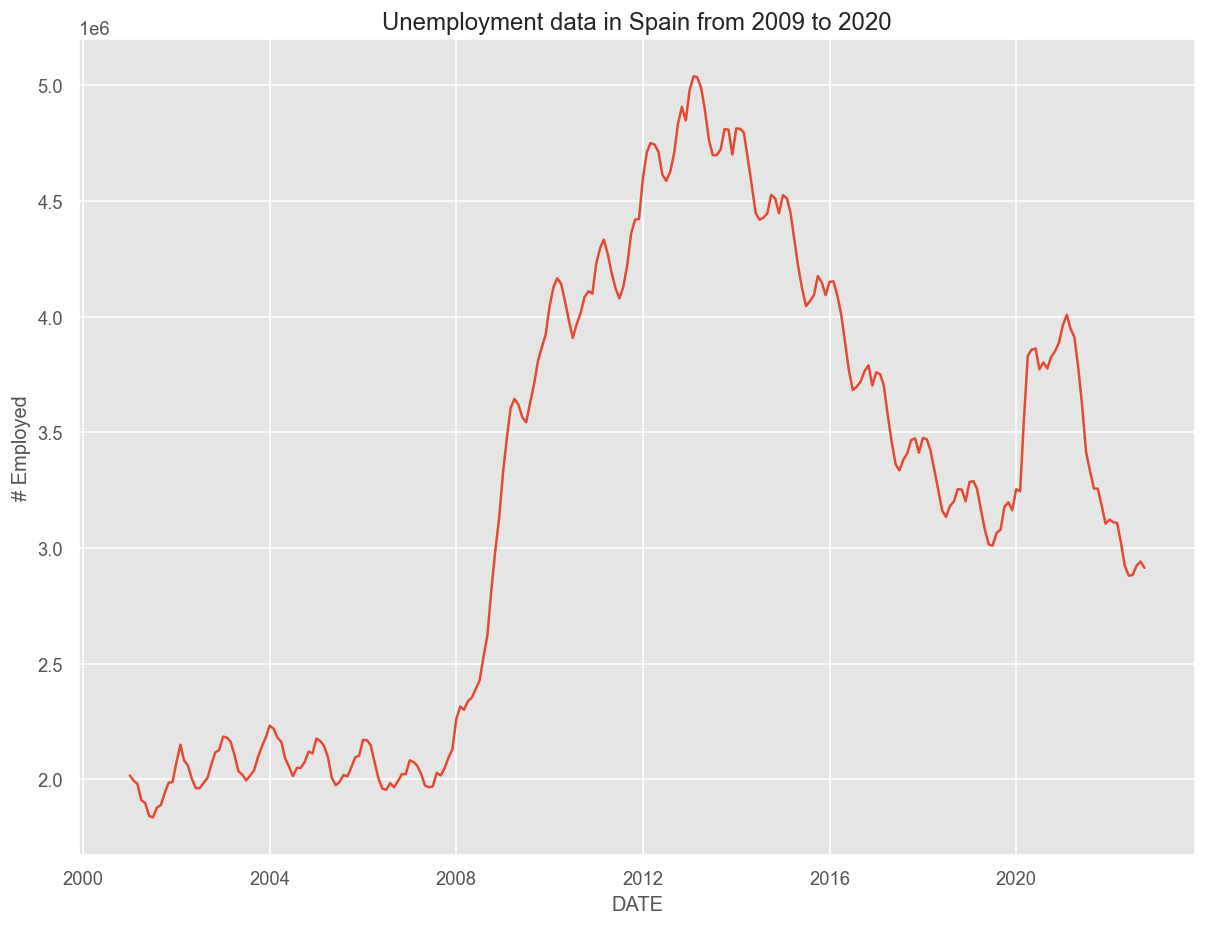

In [116]:
# Plotting a time series
fig, ax = plt.subplots()
ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from 2009 to 2020', xlabel='DATE', ylabel='# Employed')
plt.show()

Vemos que no hay constancia ni en la media ni en la varianza, por lo que deberemos estabilizarlas.

Viendo esta serie, aun no puedo saber si es autorregresiva, ruido blanco o lo que sea.

In [5]:
df_unemployment = df[['TOTAL']] # Maintain data.frame format for column
df_unemployment

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285
...,...
2022-06-01,2880582
2022-07-01,2883812
2022-08-01,2924240


<Figure size 960x600 with 0 Axes>

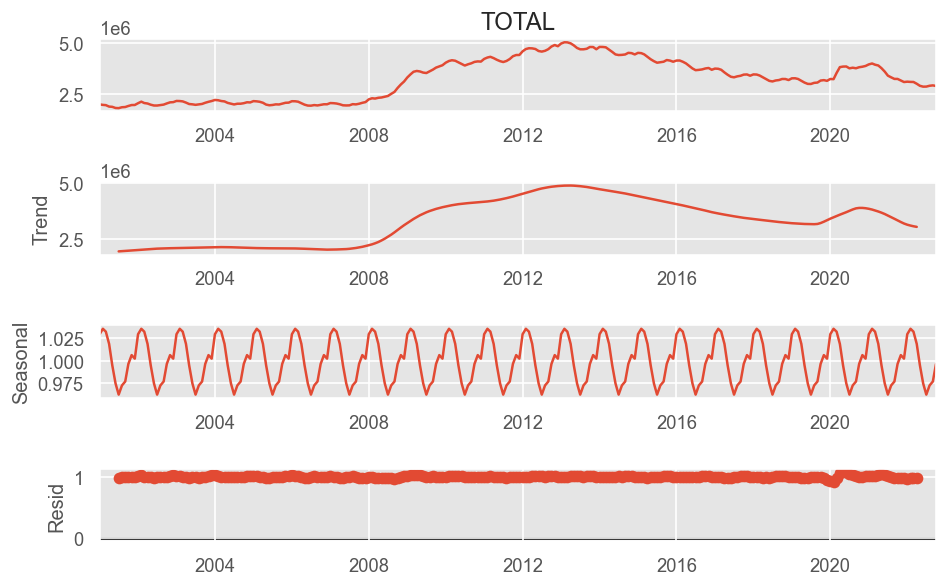

In [6]:
# Multplicative Decomposition
result_mul = seasonal_decompose(df_unemployment['TOTAL'], model='multiplicative')
plt.figure()
result_mul.plot()
plt.show()

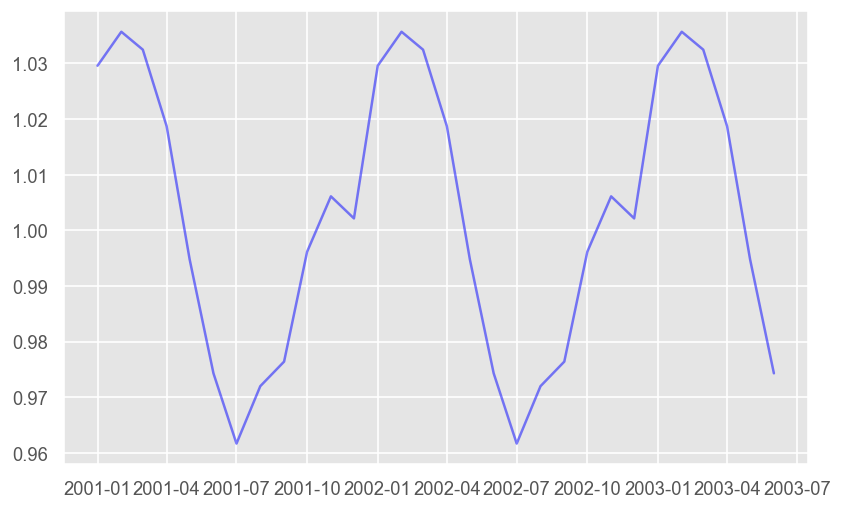

In [7]:
plt.plot(result_mul.seasonal[:30], color='blue', alpha=0.5, label='Multiplicative seasonal')


---
### Identification process

Con esta funcion, lo que estamos pintando es la serie original y las funciones de correlacion simple parcial (acf y pacf)

Los pasos a seguir son:
- 1. Identificacion (ACF yPACF)
- 2. Diagnostico
    
#### 1. Plot the series and search for possible outliers

En primer lugar pintamos la serie, viendo la correlacion vemos que tiene pinta de que la media no es estacionaria

Para comprobar la varianza, deberemos pintar Box Cox

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


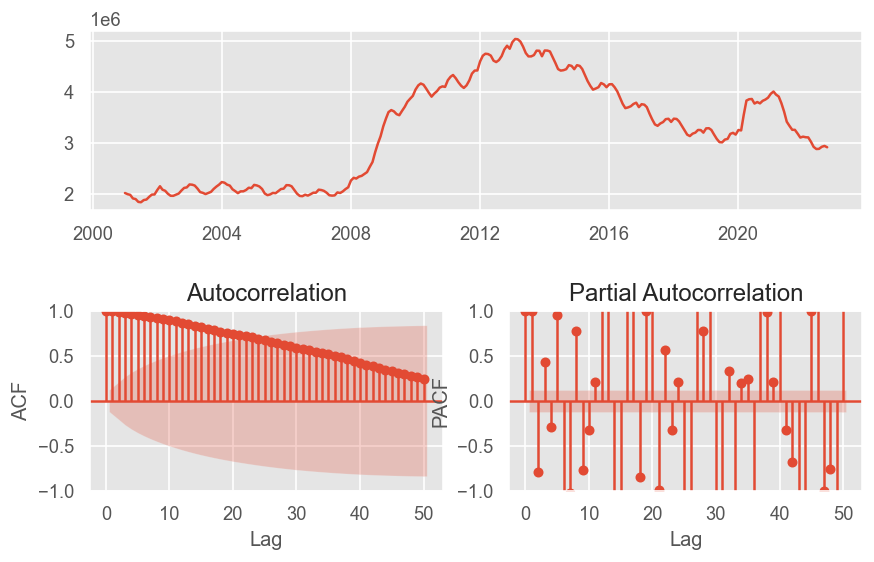

In [8]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_unemployment,lags=50)

Para pintar la siguiente gráfica, en un primer momento no sabremos cómo establecer la estacionalidad. Pondremos un número aleatorio (que creamos que tenga sentido), y estabilizaremos la varianza con ese numero.

Una vez pintemos la diferenciacion estacional (tras ejecutar boxcox para estabilizar la varianza), podremos ver la tendencia que sigue la serie en el grafico de Autocorrelacion. Mirando los picos de ese gráfico, podemos sacar la estacionalidad.

Una vez averiguada la estacionalidad real de la serie, deberemos repetir el proceso de transformacion BoxCox, pero esta vez introduciendo la estacionalidad correcta averiguada.

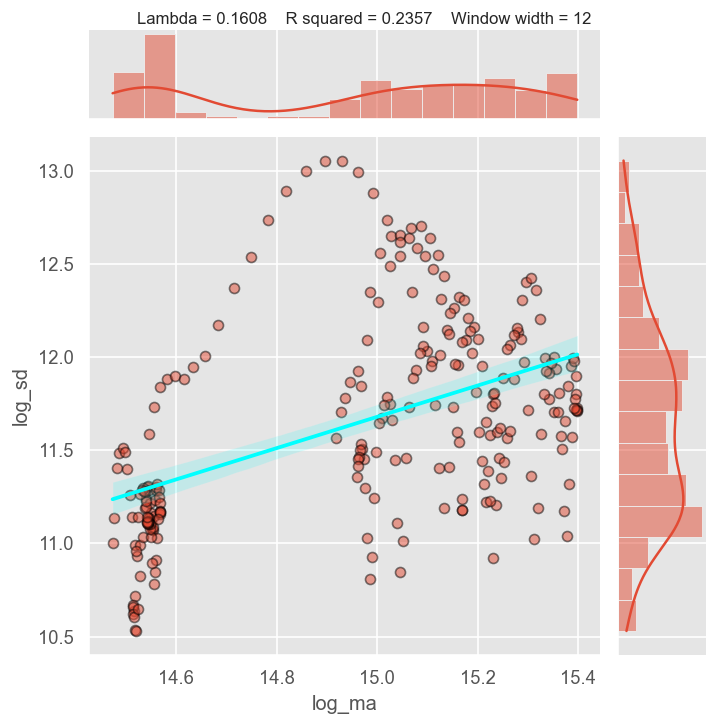

0.1607915855603168

In [9]:
FT.boxcox_lambda_plot(df_unemployment, window_width=12)

De la gráfica anterior podemos sacar el valor de lambda, que deberemos introducir en la funcion BoxCox para estabilizar la varianza

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


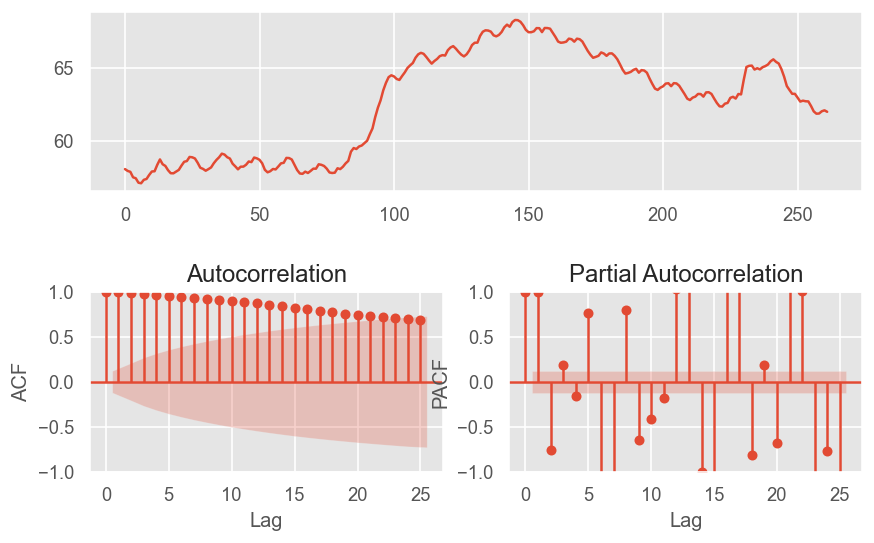

In [10]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 0.161 #Select lambda
    z = st.boxcox(df_unemployment.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_unemployment.columns.values.tolist())
else:
    z = df_unemployment

# Plot transformed data
FT.ts_display(z)

Una vez estabilizada la varianza, tengo que analizar la parte estacionaria. Si nos fijamos, vemos que claramente tenemos que diferenciar la media.

A continuacion, pintamos de nuevo la distribucion de la varianza. Vemos que ahora es una linea horizontal y que, además, el valor de lambda es muy cercano a 1. Esto nos indica que se ha estabilizado correctamente.

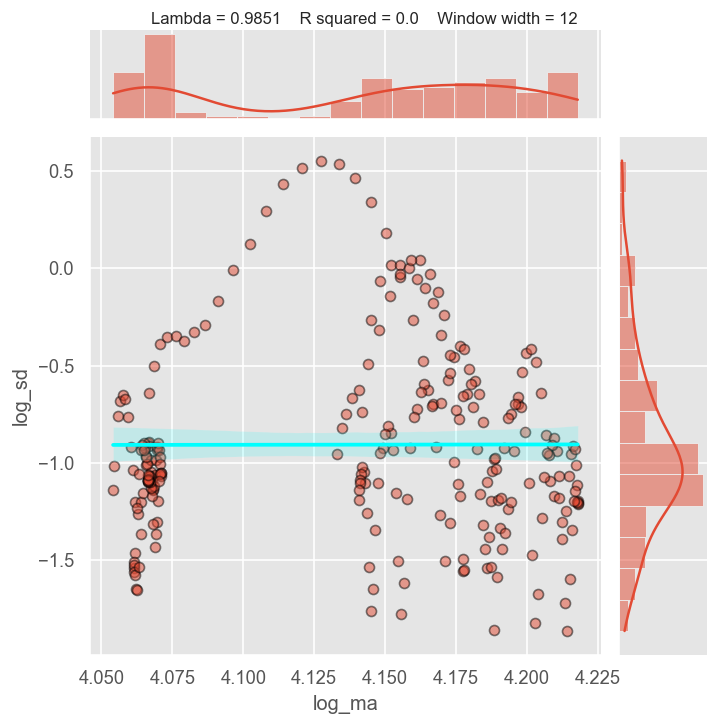

0.9850716550948463

In [11]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

#### 3. Analyze stationarity 

Vamos a aplicar el test Dickey Fuller para asegurarnos de que tenemos que diferenciar la media. Si obtenemos un pvalor mayor que 0.05, significará que debemos realizar al menos una diferenciacion.


In [12]:
# Alternative test - Augmented Dickey Fuller Test
# Aplicando este test, podemos saber si debemos realizar diferenciacion para la media o no. Si el pvalor es mayor de 0.05, se realiza diferenciacion
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.644424
p-value: 0.459950
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


Como el pvalor es mayor que 0.05, se realiza diferenciacion en la media. (d =1)

*Nota*: En primer lugar vemos que con D = 0, obtenemos un seasonality de 12 (hay un pico cada 12 puntos) Debemos hacer esto para establecer la seasonality. Lo hacemos con 0 para ver, y luego ya hacemos la transformacion boxcox con la seasonality que hayamos descubierto en este gráfico

`Diferenciacion en la media:`

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


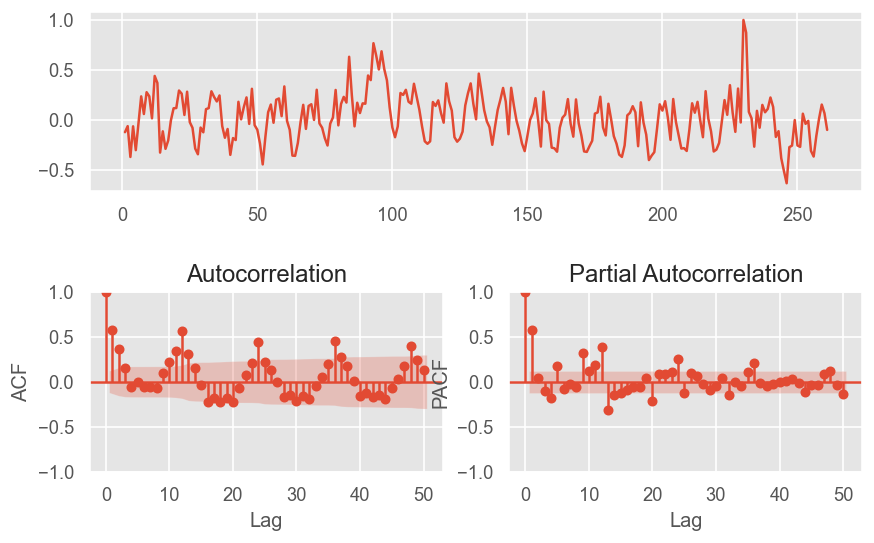

In [13]:
# Difference of the time series
d = 1 # diferenciacion regular. y(t)-y(t-q). Incremento respecto del instante anterior
D = 0 # Diferenciacion estacional. Voy a obtener una nueva serie que es y(t)- y(t-s). Incremento respecto del periodo anterior
S = 12 # Seasonality of 12 days

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Al hacer una diferenciacion de la media (d=1) vemos que se estabiliza (primer gráfico), pero la serie no es estacionaria igualmente, puesto que las autocorrelaciones no decrecen. Esto significa que debemos aumentar la correlacion estacional (D=1)

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


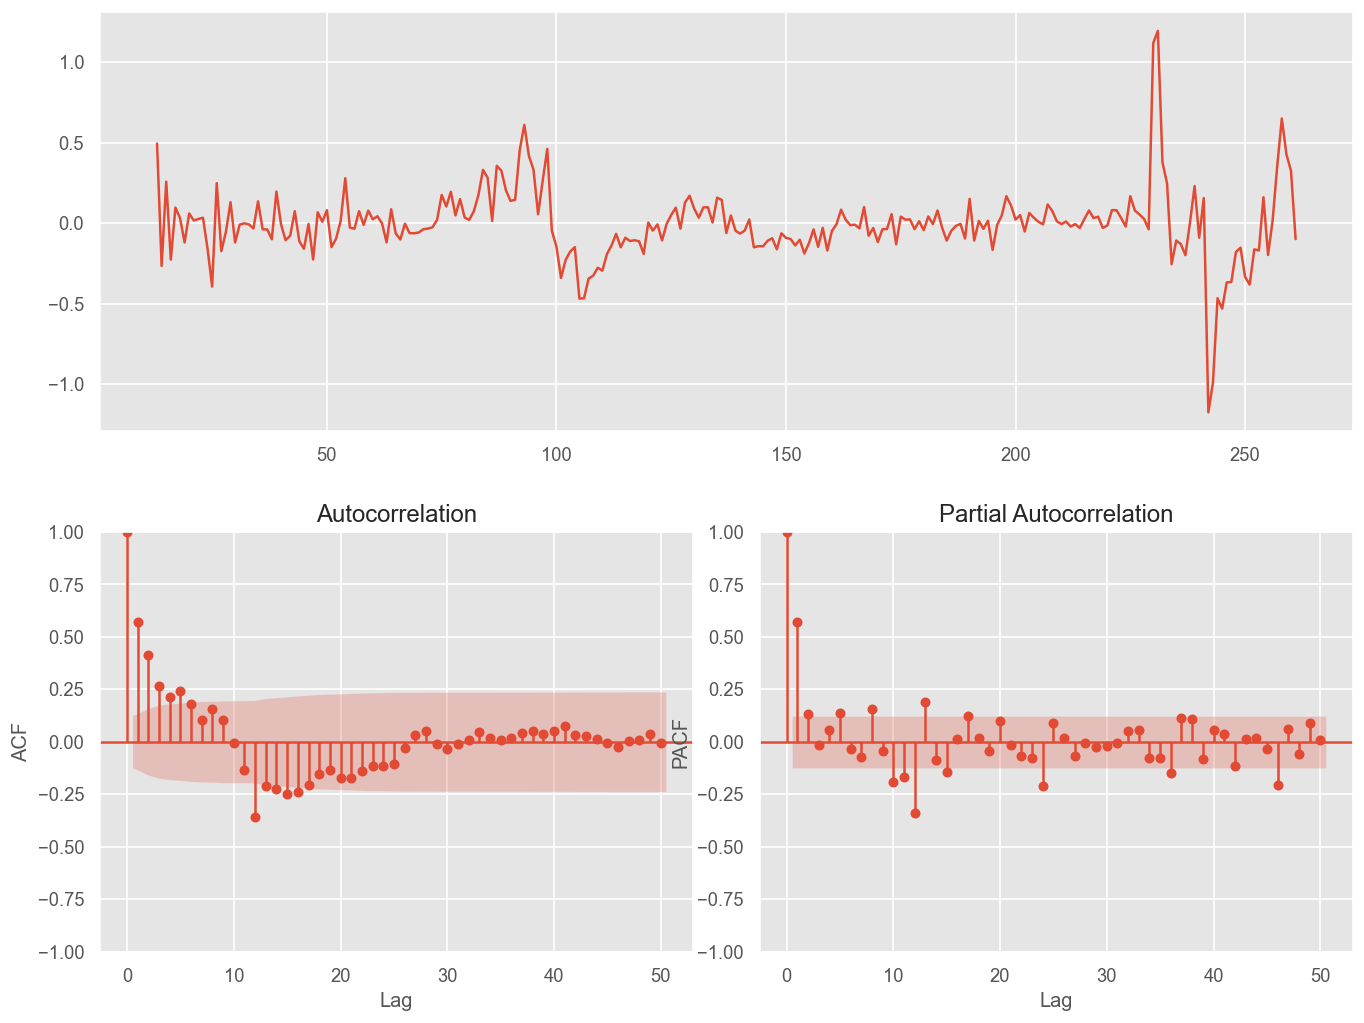

In [14]:
# Difference of the time series
d = 1 # diferenciacion regular. y(t)-y(t-q). Incremento respecto del instante anterior
D = 1 # Diferenciacion estacional. Voy a obtener una nueva serie que es y(t)- y(t-s). Incremento respecto del periodo anterior
S = 12 # Seasonality of 12 days

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values

plt.rcParams.update({'figure.figsize': (12, 9), 'figure.dpi': 120})
FT.ts_display(Bz,lags=50)

Como podemos ver en la gráfica anterior, una vez aumentada la correlacion estacional (D=1), vemos que tanto la tendencia estacional como la periodica está disminuyendo, por lo que ya tenemos la serie como queríamos y podemos empezar a ajustar el modelo de arima. 

#### 5. Fit SARIMA model and check significance of the coefficients

Vamos a analizar los gráficos de ACF y PACF obtenidos anteriormente para establecer los mejores parámetros para ajustar nuestro modelo.
- Fijandonos en la parte regular tenemos dos opciones:
    - ACF 3 o 4, lo que implica un MA de orden 3 (más simple)
    - PACF 1 o 2, lo que implica un AR de orden 1

    Empezaremos por probar el modelo más simple (AR de orden 1), para ver como se ajusta.


- Fijandonos en la parte estacional. (Barras localizadas en los multiplos de 12 (seasonality))
    - En primer lugar hemos comprobado que queremos diferenciar (para conseguir decrecer la autocorrelacion)
    - ACF de orden 1 (Una unica barra en el 12) --> MA de orden 1
    - PACF de orden 2 o 3 (Barras en 12, 24 y puede que 36) --> AR de orden 2
    - Seasonality de 12, como ya hemos visto

    Al igual que en la parte regular, comenzaremos probando el modelo más simple (MA de orden 1), para ver cómo se comportan las predicciones


In [15]:
# Fit model with estimated order
'''
AR --> (p) PACF
MA --> (q) ACF
Orden --> (p,d,q)
'''
sarima_fit = SARIMAX(z, 
                    order=(1,1,0), # Regular components (p,d,q) --> en el d ponemos un 1 porque hemos decidido diferenciar. AR(1)
                    seasonal_order=(0, 1, 1, 12),  # Seasonal components [P,D,Q,S] --> Estacionales - MA(1)
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 128.453
Date:                              Wed, 30 Nov 2022   AIC                           -250.905
Time:                                      10:20:08   BIC                           -240.514
Sample:                                           0   HQIC                          -246.716
                                              - 262                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6786      0.028     23.950      0.000       0.623       0.734
ma.S.L12      -0.8464      0.043    -19.569      0.000      -0.931      -0.762
sigma2         0.0190      0.001     33.578      0.000       0.018       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              3865.02
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             2.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ajustando el modelo vemos que los pvalores de todos los coeficientes son son 0, lo cual es buena señal. A su vez, obtenemos un AIC negativo.

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.370812    0.82625


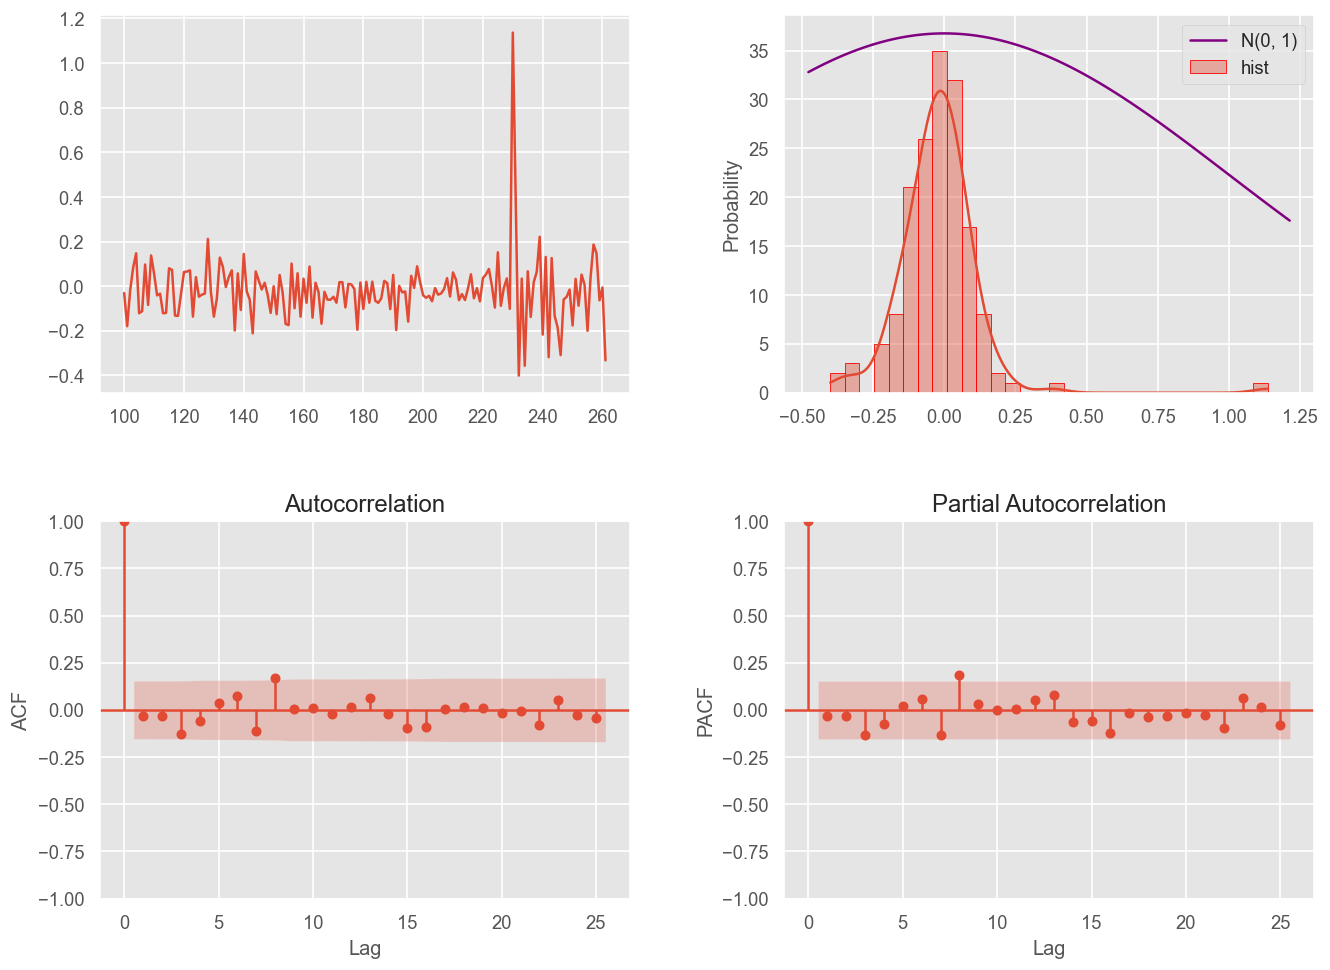

In [16]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

Al pintar los residuos vemos que prácticamente hemos obtenido ruido blanco (errores de mi modelo que asumo porque no soy capaz de modelar), por lo que deducimos que es un buen modelo.

A continuacion, vamos a realizar las predicciones para el mes que viene con el modelo que hemos entrenado.

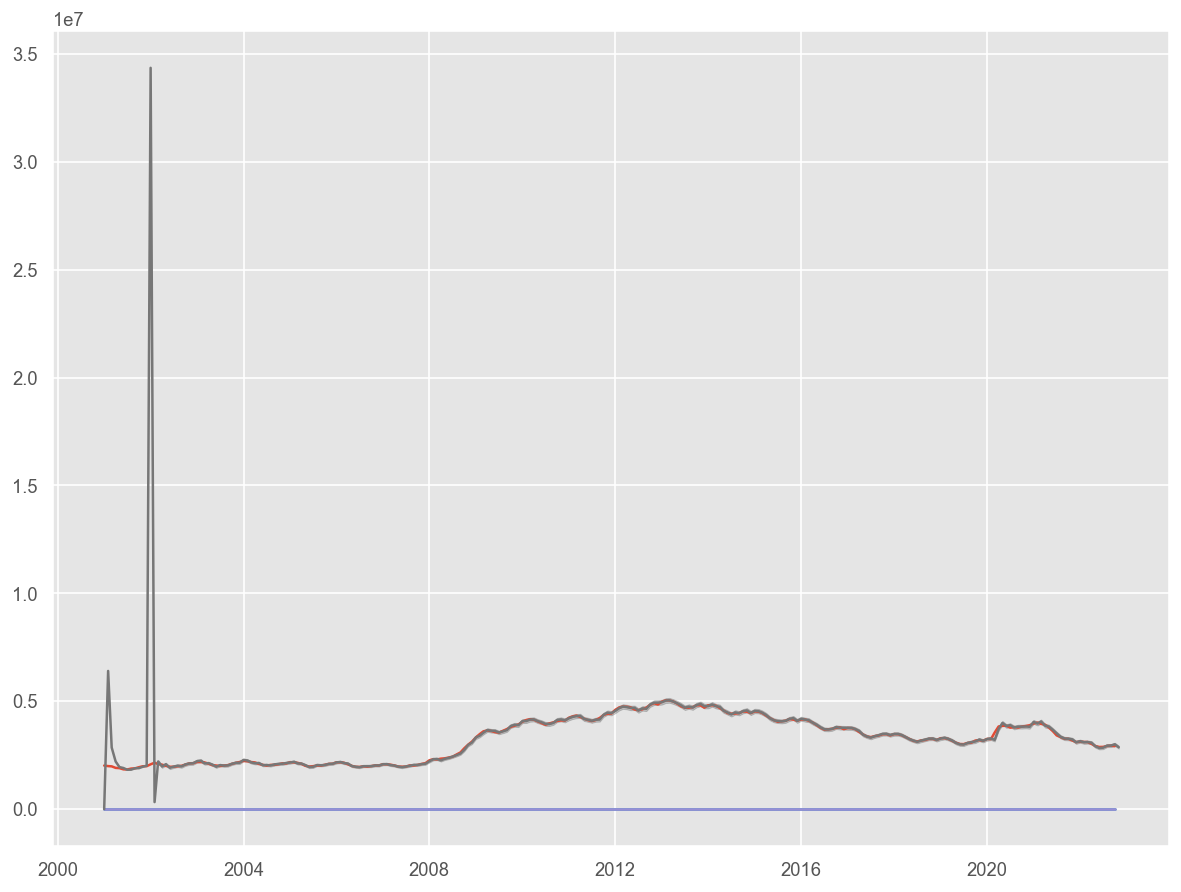

In [187]:
#Obtain forecasts for in-sample and out-of-sample
start = 0
horizon = 1 # El mes siguiente
end = df_unemployment["TOTAL"].shape[0] + horizon

pred = sarima_fit.get_prediction(start = start, end=end, dynamic=False)
print(pred)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

# Obtener las fechas de la prediccion (indice de fecha en nuestro df)
dates_to_plot = []
num_index = np.arange(start, end+1)
for i in range(0, len(num_index)):
    # Vamos añadiendo meses para pintar el indice de yhat
    d = df_unemployment.index[start] + pd.DateOffset(months=i)
    dates_to_plot.append(d)
yhat.index = dates_to_plot
yhat_conf_int.index = dates_to_plot

initial_date = df_unemployment.index[start]
plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_unemployment.loc[initial_date:, :])
plt.plot(yhat)
plt.show()

In [214]:
yhat

2001-01-01    2.025297e+06
2001-02-01    2.051653e+06
2001-03-01    2.053641e+06
2001-04-01    1.984016e+06
2001-05-01    1.915472e+06
                  ...     
2022-08-01    2.966539e+06
2022-09-01    2.983315e+06
2022-10-01    3.040791e+06
2022-11-01    3.034640e+06
2022-12-01    3.027302e+06
Name: yhat, Length: 264, dtype: float64

In [215]:
#Error MAE - Mean Absolute error
print('MAE:',mean_absolute_error(df_unemployment['TOTAL'], yhat[:-2]))
#Error RMSE - Root Mean Square Error
print('RMSE:',math.sqrt(mean_squared_error(df_unemployment['TOTAL'], yhat[:-2])))
#Error r^2 
print('R2:',r2_score(df_unemployment['TOTAL'], yhat[:-2]))

MAE: 51148.53319202079
RMSE: 76170.05661524988
R2: 0.9940209067737331


In [ ]:
#Training and test RMSE - Root Mean Square Error

print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['DEM'], dfTS_eval['MLP_pred'])))

print('Test R2:',r2_score(dfTS_eval['DEM'], dfTS_eval['MLP_pred']))

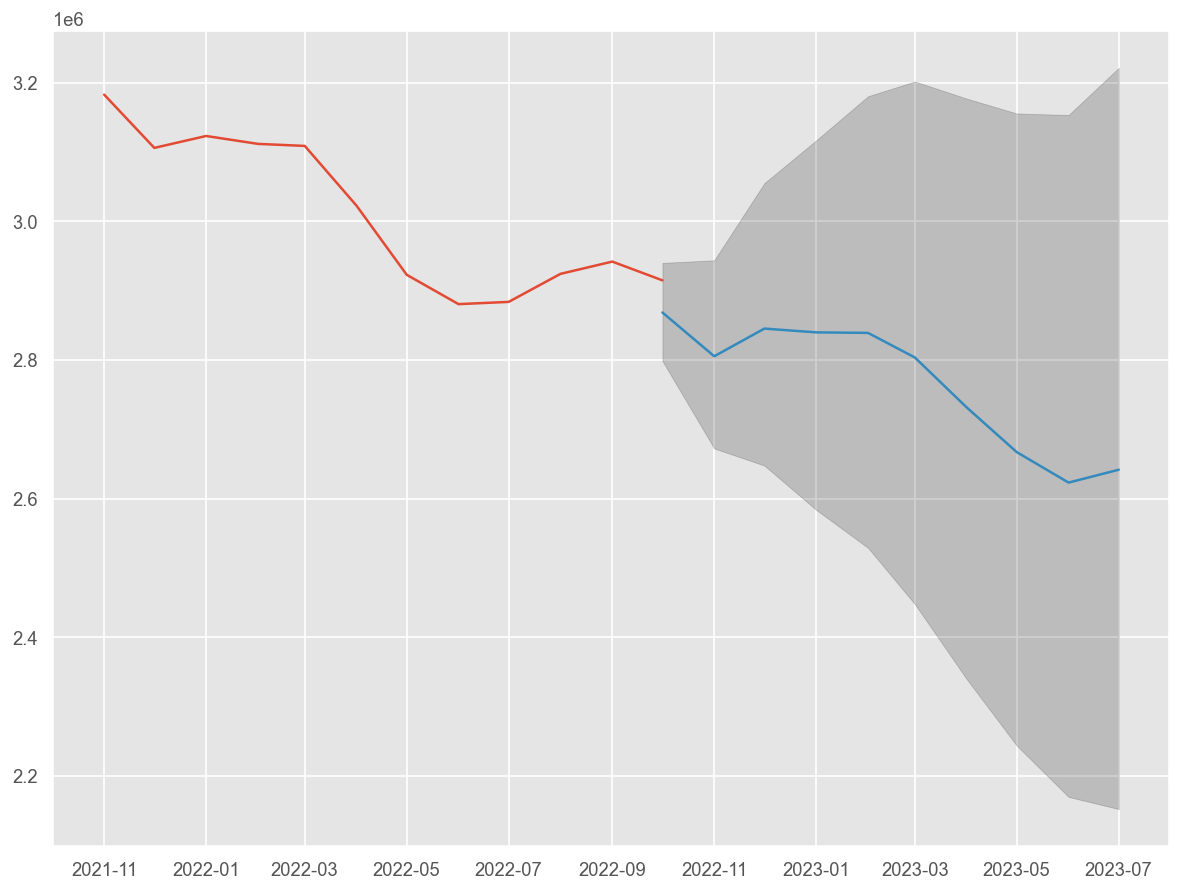

In [178]:
# Plot prediction of out_of_sample and confidence intervals
start = 250
horizon = 10 # El mes siguiente
end = df_unemployment["TOTAL"].shape[0] + horizon

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
print(pred)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

# Obtener las fechas de la prediccion (indice de fecha en nuestro df)
dates_to_plot = []
num_index = np.arange(start, end+1)
for i in range(0, horizon):
    # Vamos añadiendo meses para pintar el indice de yhat
    d = df_unemployment.index[-1] + pd.DateOffset(months=i)
    dates_to_plot.append(d)

yhat.index = dates_to_plot
yhat_conf_int.index = dates_to_plot
initial_date = df_unemployment.index[start]
plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_unemployment["TOTAL"].loc[initial_date:])
plt.plot(yhat)
plt.show()

In [19]:
# Ahora podemos obtener el numero de personas que predice nuestro modelo 
num_parados_noviembre = yhat.loc["2022-11-01"]
num_parados_octubre = df_unemployment.loc["2022-10-01"]["TOTAL"]
print(f"El numero de parados en octubre fue de {num_parados_octubre} personas.")
print(f"Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: {num_parados_noviembre} personas")

El numero de parados en octubre fue de 2914892 personas.
Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: 2805379.798921724 personas


--- 
#### 5. Fit SARIMAX time series

##### 1. Preparing the dataset

In [21]:
linear_covid = np.arange(0,1,1/len(df_unemployment.loc["2020-03-01":]))
linear_covid = linear_covid[::-1]
linear_covid

array([0.96875, 0.9375 , 0.90625, 0.875  , 0.84375, 0.8125 , 0.78125,
       0.75   , 0.71875, 0.6875 , 0.65625, 0.625  , 0.59375, 0.5625 ,
       0.53125, 0.5    , 0.46875, 0.4375 , 0.40625, 0.375  , 0.34375,
       0.3125 , 0.28125, 0.25   , 0.21875, 0.1875 , 0.15625, 0.125  ,
       0.09375, 0.0625 , 0.03125, 0.     ])

In [22]:
uniform_covid = np.random.uniform(0, 1,size=len(df_unemployment.loc["2020-03-01":]))
uniform_covid = np.sort(uniform_covid) 
uniform_covid = uniform_covid[::-1]
# plt.plot(uniform_covid)

In [23]:
# vamos a añadir una columna nueva a nuestro dataframe, indicando con un 0 la epoca en la que no había covid y con un 1 en la que sí
# además, en el rango de fechas en el que si hay covid, vamos a generar una rampa (Decay), para darle más o menos peso al covid en 
# funcion de si estamos más o menos cerca de la cuarentena (Que, como hemos visto, provocó el pico maximo de paro de esas fechas)

# en concreto, vamos a generar dos columnas, una para un linear decay, en el que estaremos indciandole al modelo que el covid decrece linealmente
# y un exponential decay, en el que estaremos indicandole un decrecimiento exponencial de la importancia del covid, y compararemos ambos, para ver cuál se ajusta mejor

df_unemployment["COVID_L"] = 0

df_unemployment.loc["2020-03-01":, "COVID_L"] = linear_covid
df_unemployment

,TOTAL,COVID_L
DATE,,
2001-01-01,2017389,0.00000
2001-02-01,1993273,0.00000
2001-03-01,1981006,0.00000
2001-04-01,1910453,0.00000
2001-05-01,1898285,0.00000
...,...,...
2022-06-01,2880582,0.12500
2022-07-01,2883812,0.09375
2022-08-01,2924240,0.06250


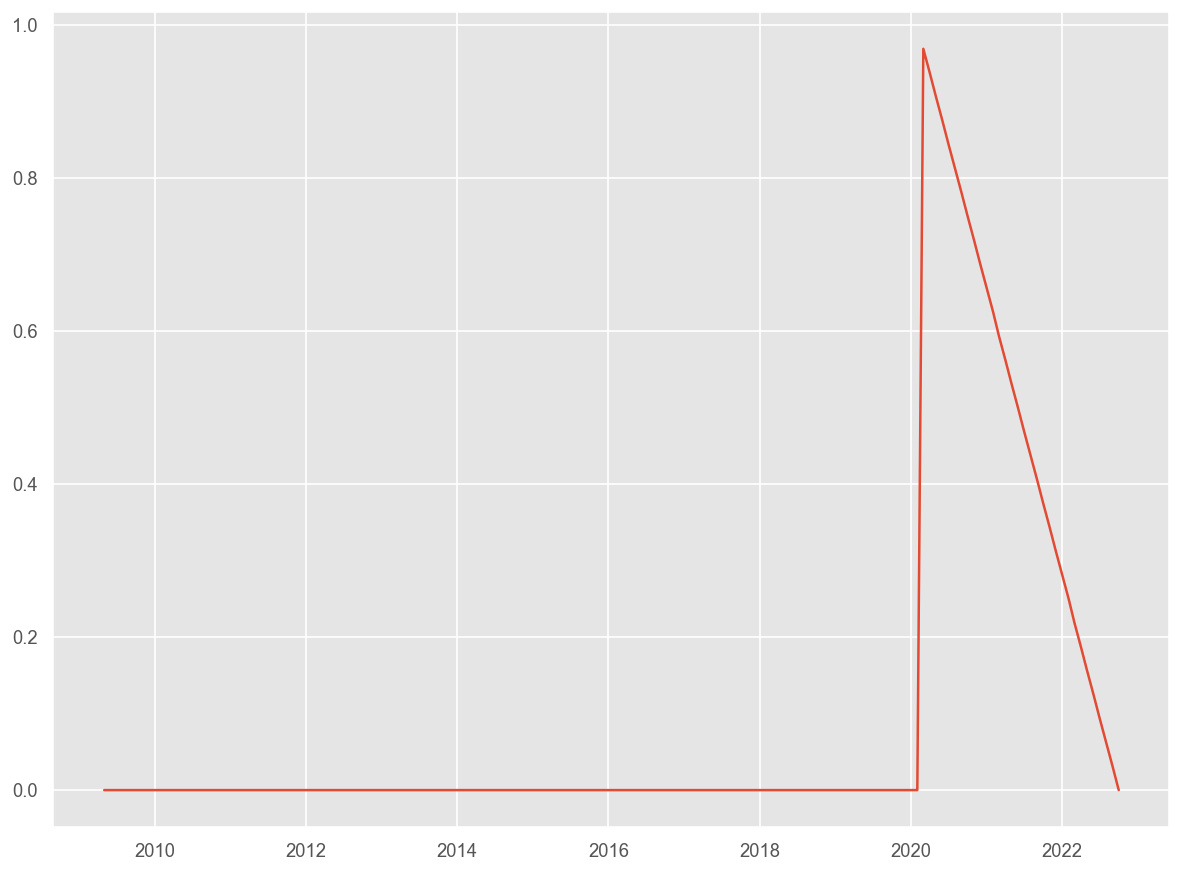

In [24]:
plt.plot(df_unemployment[100:]["COVID_L"])
plt.show()

In [25]:
df_unemployment['COVID_U'] = 0

df_unemployment.loc["2020-03-01":, "COVID_U"] = uniform_covid
df_unemployment

,TOTAL,COVID_L,COVID_U
DATE,,,
2001-01-01,2017389,0.00000,0.000000
2001-02-01,1993273,0.00000,0.000000
2001-03-01,1981006,0.00000,0.000000
2001-04-01,1910453,0.00000,0.000000
2001-05-01,1898285,0.00000,0.000000
...,...,...,...
2022-06-01,2880582,0.12500,0.139505
2022-07-01,2883812,0.09375,0.089882
2022-08-01,2924240,0.06250,0.066378


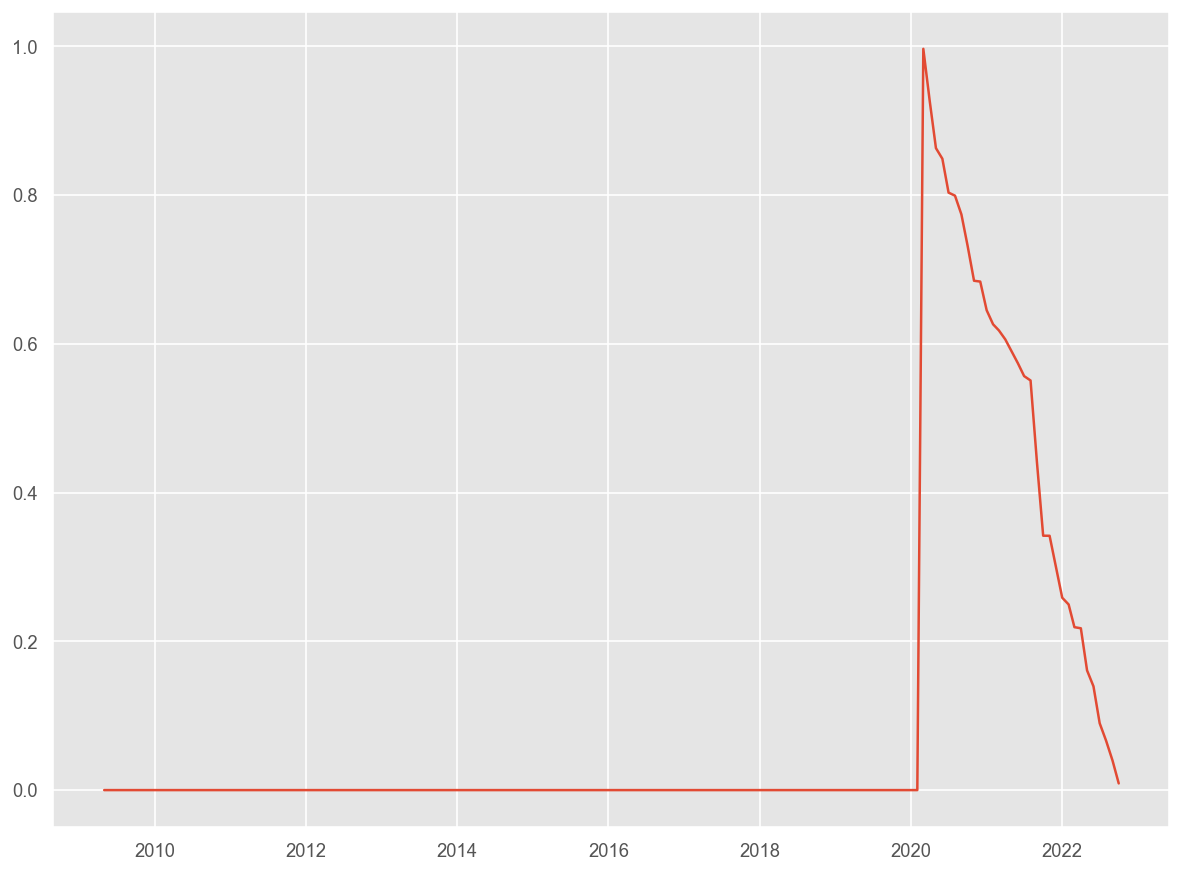

In [26]:
plt.plot(df_unemployment[100:]["COVID_U"])
plt.show()

In [27]:
df_unemployment_save = df_unemployment.copy()

In [28]:
df_unemployment = df_unemployment_save.copy()

In [29]:
# Define input and output matrices
INPUTS = ['COVID_L', 'COVID_U']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df_unemployment[INPUTS]
y = df_unemployment[OUTPUT]


Ahora, configuramos el modelo para que entrene con el set de datos de entrenamiento que hemos generado.

Establecemos los mismos ordenes (tanto regulares como de seasonality) que hemos seleccionado para el modelo de SARIMA 

In [30]:
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = y, 
                            trend = 'c',
                            order=(1,1,3), # Regular components (p,d,q)
                            seasonal_order=(1, 1, 1, 12),  # Seasonal components [P,D,Q,S] 
                            #  ORDEN DE SARIMA (anterior)
                            # order=(1,1,0), # Regular components (p,d,q) --> en el d ponemos un 1 porque hemos decidido diferenciar. AR(1)
                            # seasonal_order=(0, 1, 1, 12),  # Seasonal components [P,D,Q,S] --> Estacionales - MA(1)
                            exog = X,
                            enforce_invertibility=False, 
                            enforce_stationarity=False)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
res_sarimax.summary()

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 3)x(1, 1, [1], 12)   Log Likelihood               -2817.260
Date:                              Wed, 30 Nov 2022   AIC                           5654.520
Time:                                      10:20:11   BIC                           5689.031
Sample:                                  01-01-2001   HQIC                          5668.437
                                       - 10-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     93.9885   1814.366      0.052      0.959   -3462.103    3650.080
COVID_L     1.367e+06   2.21e+05      6.189      0.000    9.34e+05     1.8e+06
COVID_U    -1.005e+06   1.98e+05     -5.078      0.000   -1.39e+06   -6.17e+05
ar.L1          0.8519      0.090      9.482      0.000       0.676       1.028
ma.L1         -0.4166      0.111     -3.741      0.000      -0.635      -0.198
ma.L2          0.0224      0.106      0.212      0.832      -0.185       0.229
ma.L3         -0.0866      0.059     -1.459      0.144      -0.203       0.030
ar.S.L12      -0.2747      0.065     -4.220      0.000      -0.402      -0.147
ma.S.L12      -0.1177      0.049     -2.391      0.017      -0.214      -0.021
sigma2       2.16e+09     94.602   2.28e+07      0.000    2.16e+09    2.16e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2810.01
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.35   Skew:                             1.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.78e+22. Standard errors may be unstable.
"""

Al pintar los residuos, podemos observar que obtenemos ruido blanco, lo que nos indica que nuestro modelo está ajustando correctamente

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\mltools\forecast_tools.py:86: RuntimeWarning: invalid value encountered in true_divide
  y_pdf = y1 * y_pdf / np.max(y_pdf)
c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  29.799141   0.989644


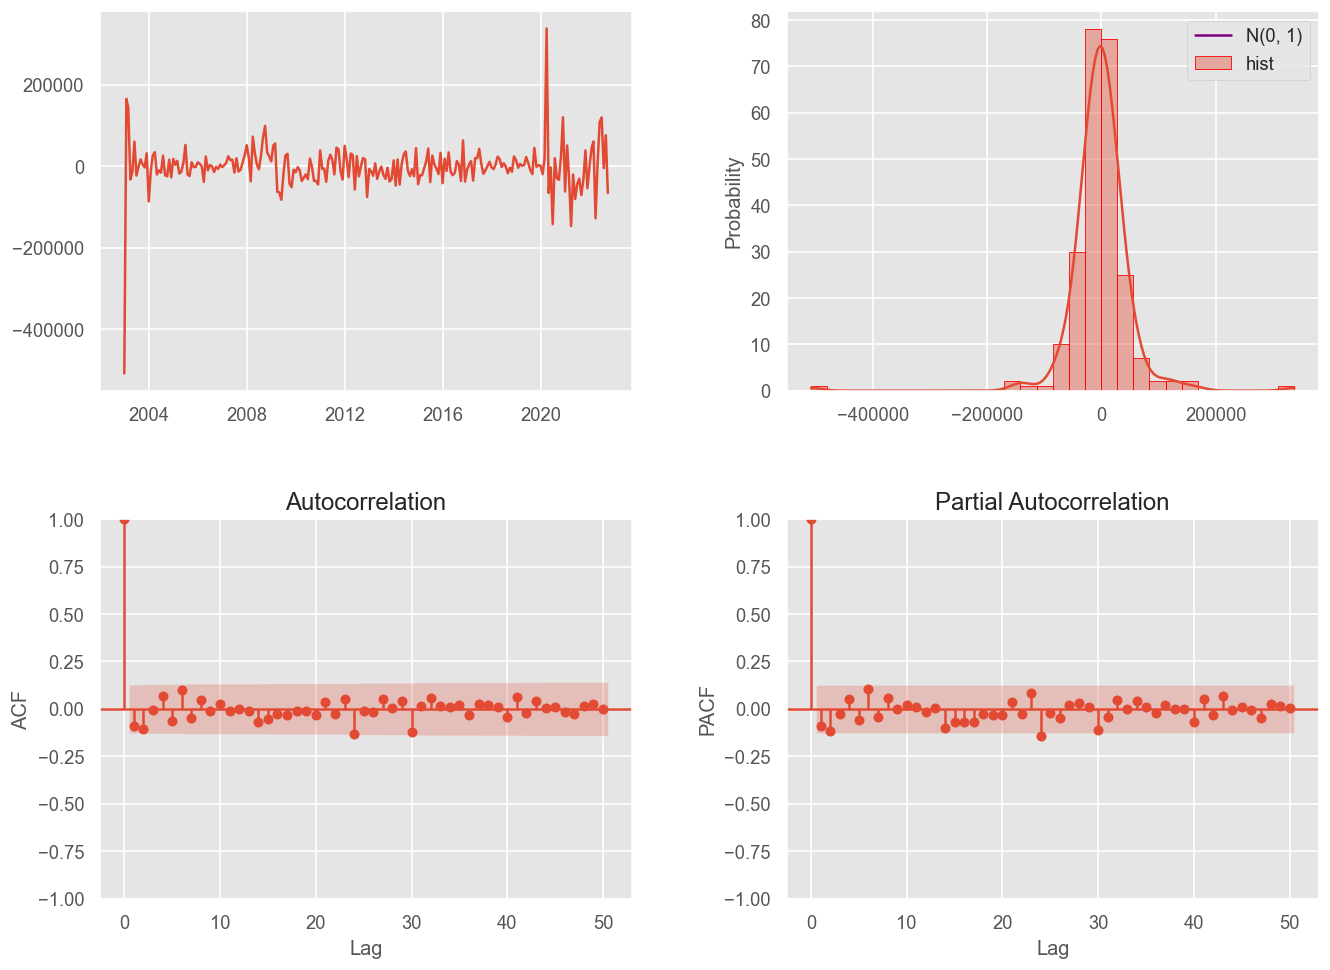

In [31]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (12, 9), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.loc["2003-01-01":]),lags=50)

Podemos pintar los graficos de ACF y PACF de forma independiente para poder observarlos con mayor detalle

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


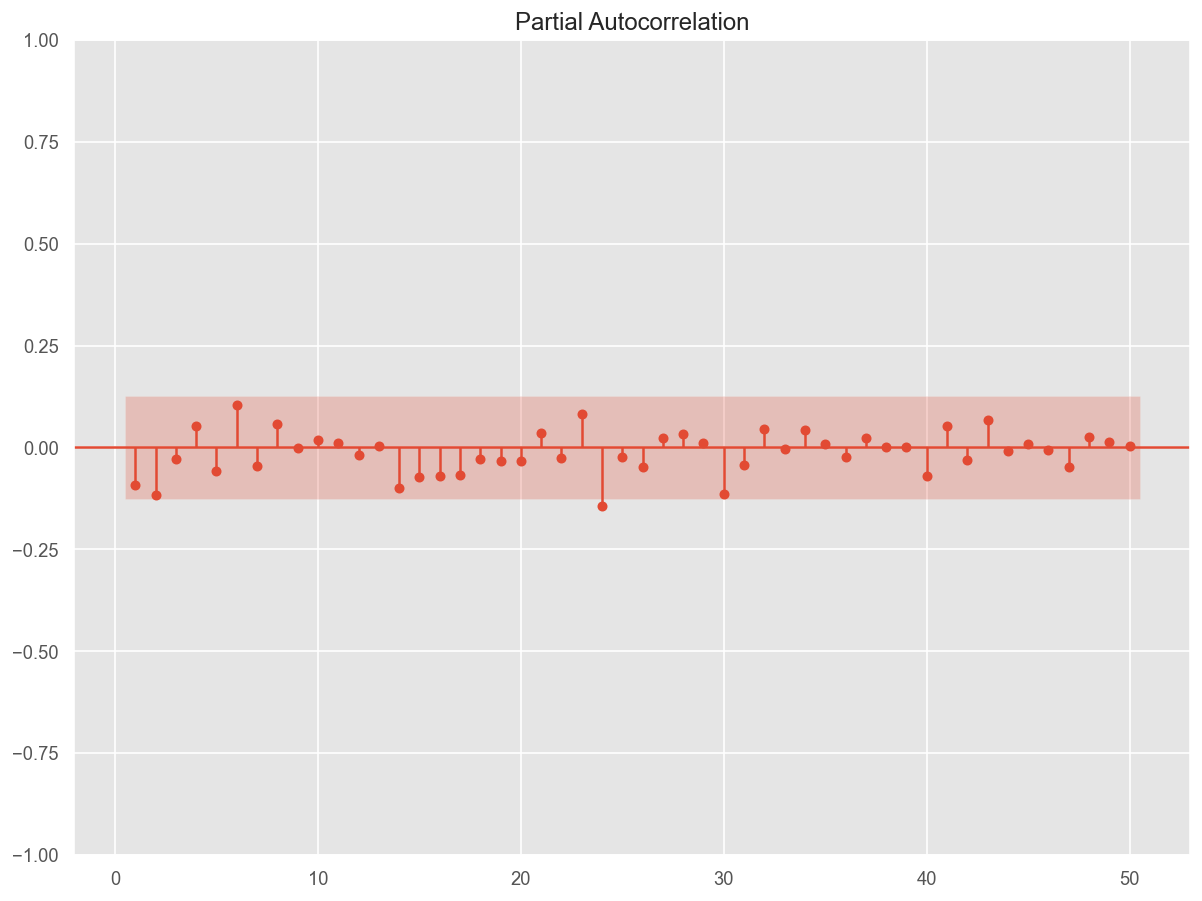

<Figure size 1440x1080 with 0 Axes>

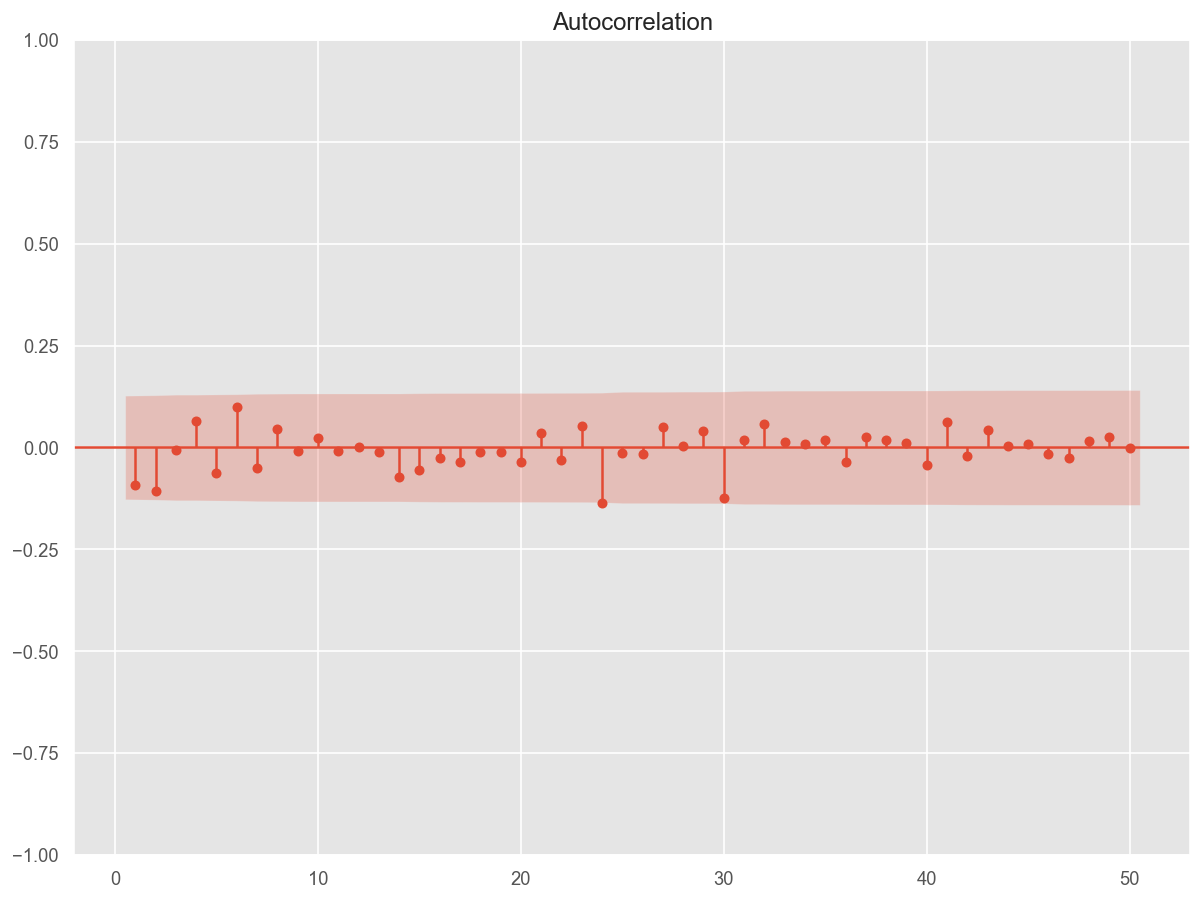

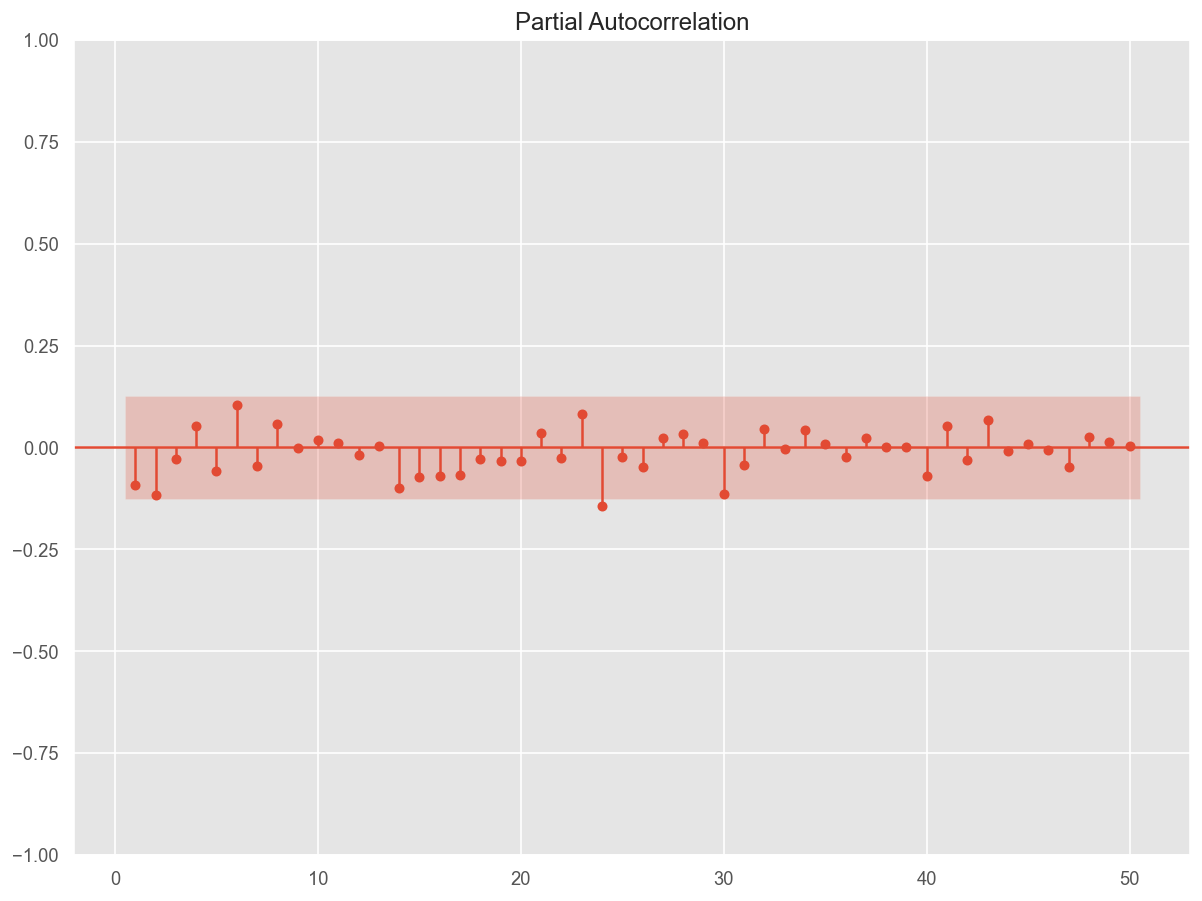

In [32]:
#Bigger plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure()
plot_acf(res_sarimax.resid.loc["2003-01-01":], lags=50,zero=False)
plot_pacf(res_sarimax.resid.loc["2003-01-01":], lags=50,zero=False)

Una vez hemos comprobador que tenemosruido blanco en nuestros residuos, podemos pasar a pintar las predicciones de nuestro modelo

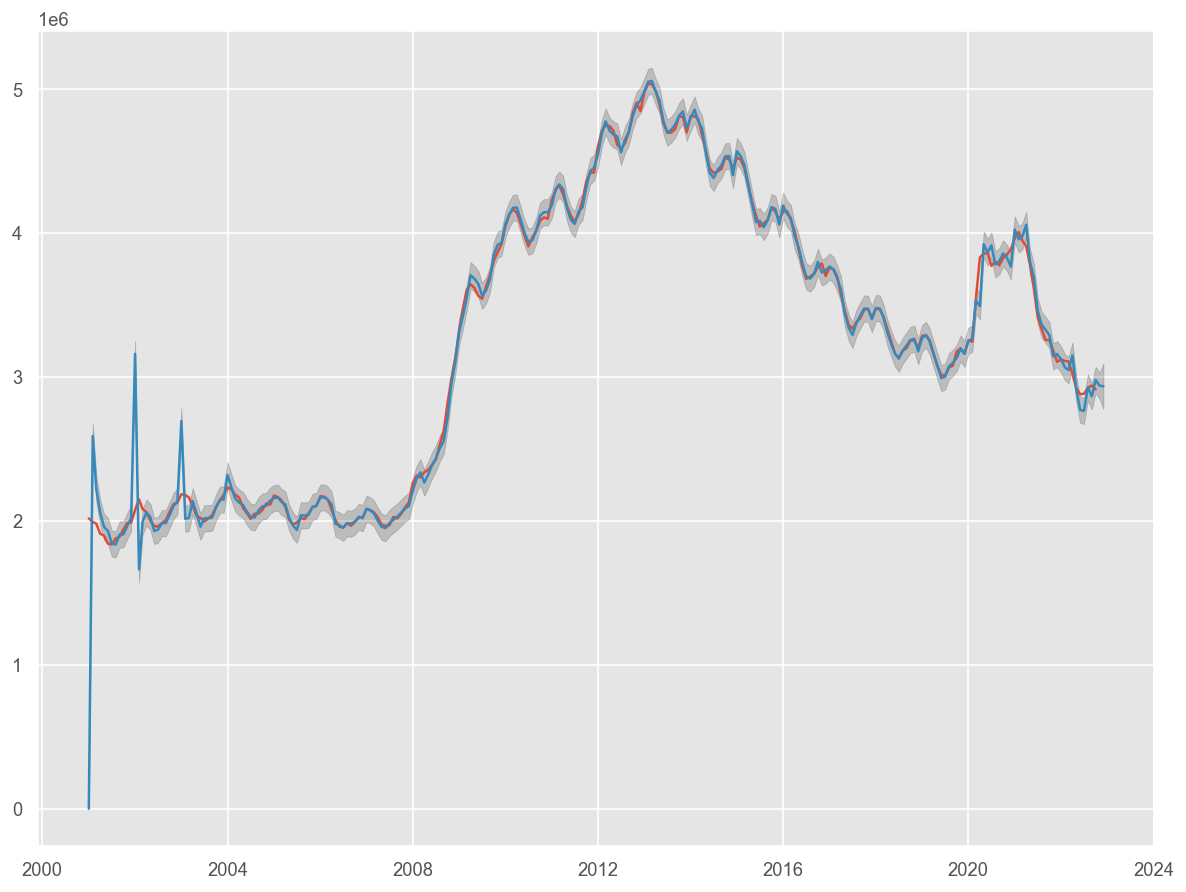

In [203]:
#Obtain forecasts for in-sample and out-of-sample
start = 0
horizon = 1
end = df_unemployment.shape[0] + horizon

pred = res_sarimax.get_prediction(start=start, 
                                    end= end, 
                                    exog = df_unemployment[INPUTS][0:2],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

initial_date = df_unemployment.index[start]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_unemployment["TOTAL"].loc[initial_date:])
plt.plot(yhat)
plt.show()

In [205]:
yhat

2001-01-01    0.000000e+00
2001-02-01    2.590357e+06
2001-03-01    2.221528e+06
2001-04-01    2.057493e+06
2001-05-01    1.957957e+06
                  ...     
2022-08-01    2.928888e+06
2022-09-01    2.865755e+06
2022-10-01    2.980270e+06
2022-11-01    2.940305e+06
2022-12-01    2.935593e+06
Freq: MS, Name: predicted_mean, Length: 264, dtype: float64

In [206]:
#Error MAE - Mean Absolute error
print('MAE:',mean_absolute_error(df_unemployment['TOTAL'], yhat[:-2]))
#Error RMSE - Root Mean Square Error
print('RMSE:',math.sqrt(mean_squared_error(df_unemployment['TOTAL'], yhat[:-2])))
#Error r^2 
print('R2:',r2_score(df_unemployment['TOTAL'], yhat[:-2]))

MAE: 47629.181132824124
RMSE: 159746.2411032841
R2: 0.9737016764721297


In [34]:
# Ahora podemos obtener el numero de personas que predice nuestro modelo 
num_parados_noviembre = yhat.loc["2022-11-01"]
num_parados_octubre = df_unemployment.loc["2022-10-01"]["TOTAL"]
print(f"El numero de parados en octubre fue de {num_parados_octubre} personas.")
print(f"Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: {num_parados_noviembre} personas")

El numero de parados en octubre fue de 2914892.0 personas.
Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: 2940305.464631225 personas


--- 
# PROPHET

#### Treating COVID-19 lockdowns as a one-off holidays

In [141]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-06-06', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2020-10-27', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-02-17', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-06-06,0,2020-10-27,143
2,lockdown_3,2020-10-27,0,2021-02-17,113
3,lockdown_4,2021-02-17,0,2021-06-10,113


In [142]:
# configuramos el df para que cumpla los estándares de prophet
df_prophet = pd.DataFrame(columns=["ds", 'y'])
df_prophet.y = df.TOTAL.copy()
df_prophet.ds = df.index.copy()
df_prophet = df_prophet.reset_index(drop=True)
df_prophet

,ds,y
0,2001-01-01,2017389
1,2001-02-01,1993273
2,2001-03-01,1981006
3,2001-04-01,1910453
4,2001-05-01,1898285
...,...,...
257,2022-06-01,2880582
258,2022-07-01,2883812
259,2022-08-01,2924240
260,2022-09-01,2941919


In [143]:
# Inicializamos prophet indicandole las vacaciones (Covid) calculadas
prophet_int2 = Prophet(holidays=lockdowns)
# ENtrenamos el modelo
prophet_int2 = prophet_int2.fit(df_prophet)
# realizamos predicciones para el proximo año
future2 = prophet_int2.make_future_dataframe(periods=365)
forecast2 = prophet_int2.predict(future2)

11:21:01 - cmdstanpy - INFO - Chain [1] start processing
11:21:01 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Lockdowns as one-off holidays')

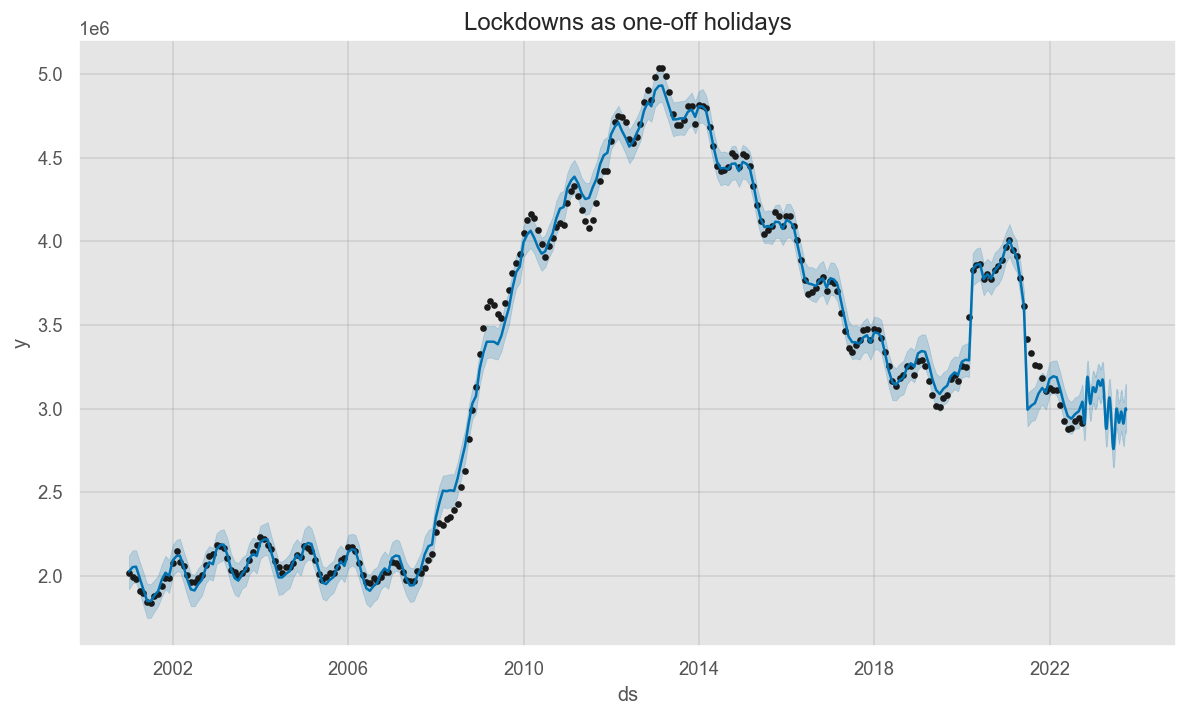

In [153]:
# Pintamos las predicciones con respecto a nuestro modelo
prophet_int2.plot(forecast2, uncertainty=True)
plt.title('Lockdowns as one-off holidays')

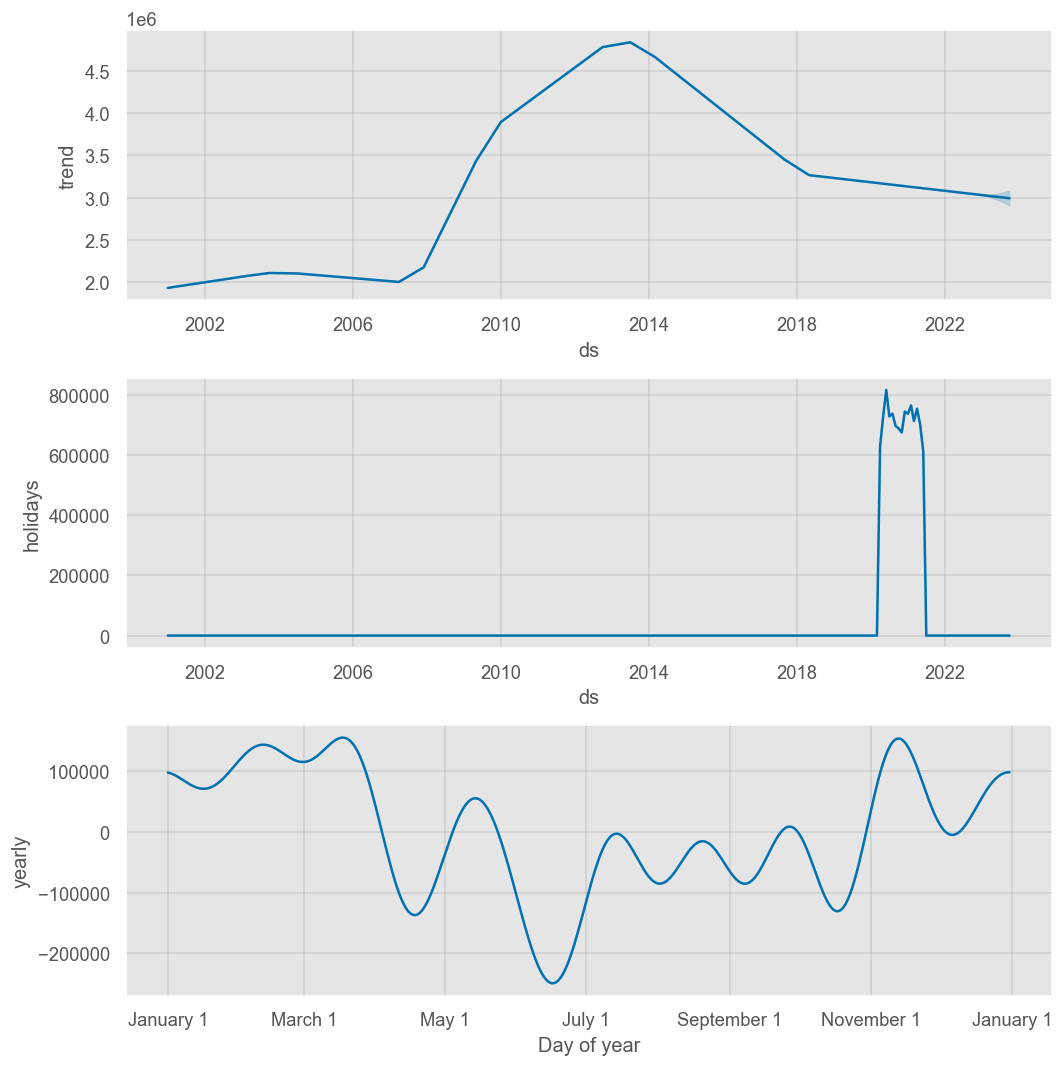

In [151]:
# Pintamos las componentes de nuestro modelo, para ver como se comportan las vacaciones
fig = prophet_int2.plot_components(forecast2)

The holiday effect can be seen in the forecast dataframe

In [133]:
forecast[(forecast['covid']).abs() > 0][['ds', 'covid']][-12:]

,ds,covid
250,2021-11-01,1.034203e+06
251,2021-12-01,1.034203e+06
252,2022-01-01,1.034203e+06
253,2022-02-01,1.034203e+06
254,2022-03-01,1.034203e+06
255,2022-04-01,1.034203e+06
256,2022-05-01,1.034203e+06
257,2022-06-01,1.034203e+06
258,2022-07-01,1.034203e+06
259,2022-08-01,1.034203e+06


In [159]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,covid,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-01,1.975026e+06,1.939625e+06,2.274770e+06,1.975026e+06,1.975026e+06,126159.474163,126159.474163,126159.474163,0.0,...,0.0,0.0,0.0,126159.474163,126159.474163,126159.474163,0.0,0.0,0.0,2.101186e+06
1,2001-02-01,1.977125e+06,1.974222e+06,2.295691e+06,1.977125e+06,1.977125e+06,157519.912404,157519.912404,157519.912404,0.0,...,0.0,0.0,0.0,157519.912404,157519.912404,157519.912404,0.0,0.0,0.0,2.134645e+06
2,2001-03-01,1.979020e+06,1.908453e+06,2.213779e+06,1.979020e+06,1.979020e+06,80464.826568,80464.826568,80464.826568,0.0,...,0.0,0.0,0.0,80464.826568,80464.826568,80464.826568,0.0,0.0,0.0,2.059485e+06
3,2001-04-01,1.981119e+06,1.875581e+06,2.196184e+06,1.981119e+06,1.981119e+06,58201.080348,58201.080348,58201.080348,0.0,...,0.0,0.0,0.0,58201.080348,58201.080348,58201.080348,0.0,0.0,0.0,2.039320e+06
4,2001-05-01,1.983150e+06,1.814426e+06,2.146853e+06,1.983150e+06,1.983150e+06,-8207.831794,-8207.831794,-8207.831794,0.0,...,0.0,0.0,0.0,-8207.831794,-8207.831794,-8207.831794,0.0,0.0,0.0,1.974942e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,2023-06-01,1.832099e+06,1.575591e+06,1.910634e+06,1.806673e+06,1.853678e+06,-92908.248555,-92908.248555,-92908.248555,0.0,...,0.0,0.0,0.0,-92908.248555,-92908.248555,-92908.248555,0.0,0.0,0.0,1.739191e+06
270,2023-07-01,1.807413e+06,1.521762e+06,1.856833e+06,1.776202e+06,1.835321e+06,-113989.825366,-113989.825366,-113989.825366,0.0,...,0.0,0.0,0.0,-113989.825366,-113989.825366,-113989.825366,0.0,0.0,0.0,1.693423e+06
271,2023-08-01,1.781904e+06,1.534757e+06,1.867055e+06,1.742242e+06,1.816314e+06,-75892.987819,-75892.987819,-75892.987819,0.0,...,0.0,0.0,0.0,-75892.987819,-75892.987819,-75892.987819,0.0,0.0,0.0,1.706011e+06
272,2023-09-01,1.756396e+06,1.538181e+06,1.865356e+06,1.709005e+06,1.795401e+06,-51327.900990,-51327.900990,-51327.900990,0.0,...,0.0,0.0,0.0,-51327.900990,-51327.900990,-51327.900990,0.0,0.0,0.0,1.705068e+06


In [164]:
prediccion_nomviembre_prophet = forecast2['yhat'].loc[forecast2.ds == "2022-11-01"].values[0]
num_parados_octubre = df_unemployment.loc["2022-10-01"]["TOTAL"]
print(f"El numero de parados en octubre fue de {num_parados_octubre} personas.")
print(f"Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: {prediccion_nomviembre_prophet} personas")

El numero de parados en octubre fue de 2914892.0 personas.
Nuestro modelo predice que el numero de parados de noviembre de 2022 es de: 3068147.931880956 personas


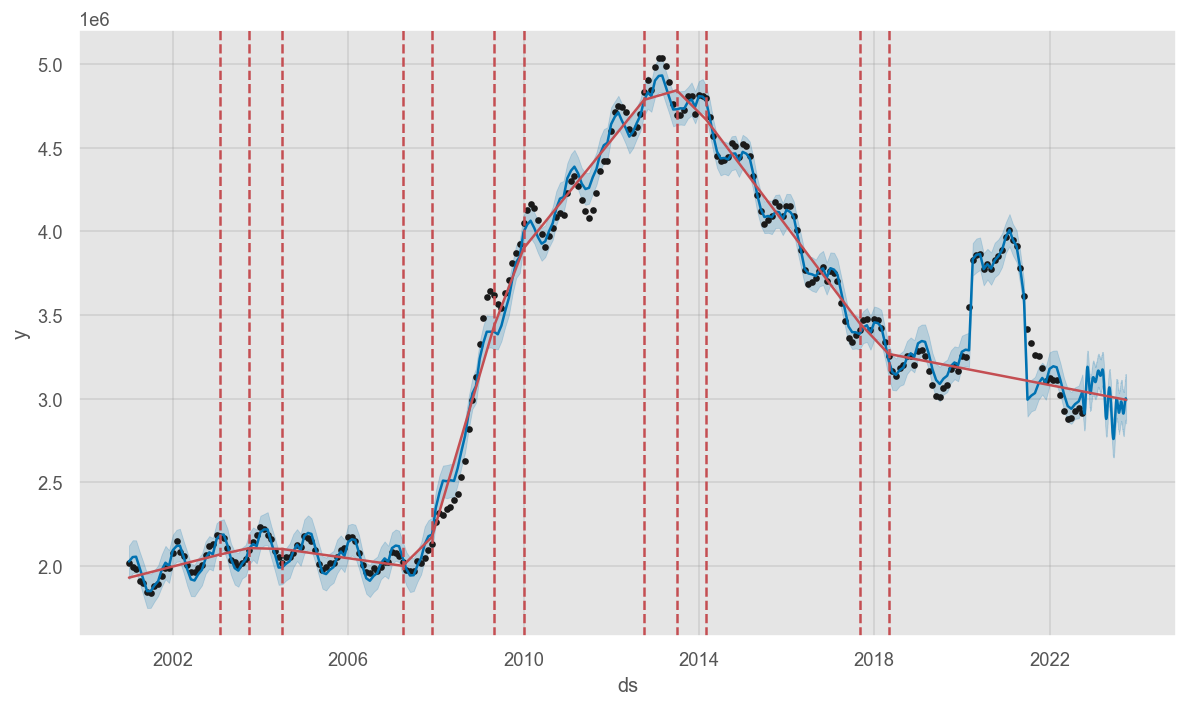

In [165]:
fig = prophet_int2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), prophet_int2, forecast2)

In [166]:
forecast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,lockdown_4,lockdown_4_lower,lockdown_4_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-01,1.928384e+06,1.919023e+06,2.120899e+06,1.928384e+06,1.928384e+06,96913.387556,96913.387556,96913.387556,0.0,...,0.0,0.0,0.0,96913.387556,96913.387556,96913.387556,0.0,0.0,0.0,2.025297e+06
1,2001-02-01,1.934056e+06,1.954266e+06,2.152503e+06,1.934056e+06,1.934056e+06,117597.235519,117597.235519,117597.235519,0.0,...,0.0,0.0,0.0,117597.235519,117597.235519,117597.235519,0.0,0.0,0.0,2.051653e+06
2,2001-03-01,1.939179e+06,1.959882e+06,2.151705e+06,1.939179e+06,1.939179e+06,114462.785872,114462.785872,114462.785872,0.0,...,0.0,0.0,0.0,114462.785872,114462.785872,114462.785872,0.0,0.0,0.0,2.053641e+06
3,2001-04-01,1.944850e+06,1.895102e+06,2.081606e+06,1.944850e+06,1.944850e+06,39165.806249,39165.806249,39165.806249,0.0,...,0.0,0.0,0.0,39165.806249,39165.806249,39165.806249,0.0,0.0,0.0,1.984016e+06
4,2001-05-01,1.950339e+06,1.821396e+06,2.019713e+06,1.950339e+06,1.950339e+06,-34867.521409,-34867.521409,-34867.521409,0.0,...,0.0,0.0,0.0,-34867.521409,-34867.521409,-34867.521409,0.0,0.0,0.0,1.915472e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,2023-09-27,2.992904e+06,2.870364e+06,3.138837e+06,2.912299e+06,3.081472e+06,8241.734326,8241.734326,8241.734326,0.0,...,0.0,0.0,0.0,8241.734326,8241.734326,8241.734326,0.0,0.0,0.0,3.001146e+06
623,2023-09-28,2.992765e+06,2.860225e+06,3.144885e+06,2.911901e+06,3.081434e+06,8066.279548,8066.279548,8066.279548,0.0,...,0.0,0.0,0.0,8066.279548,8066.279548,8066.279548,0.0,0.0,0.0,3.000832e+06
624,2023-09-29,2.992627e+06,2.868289e+06,3.145165e+06,2.911502e+06,3.081395e+06,6480.106817,6480.106817,6480.106817,0.0,...,0.0,0.0,0.0,6480.106817,6480.106817,6480.106817,0.0,0.0,0.0,2.999107e+06
625,2023-09-30,2.992488e+06,2.866179e+06,3.129980e+06,2.911104e+06,3.081357e+06,3480.264679,3480.264679,3480.264679,0.0,...,0.0,0.0,0.0,3480.264679,3480.264679,3480.264679,0.0,0.0,0.0,2.995968e+06


In [168]:
#Obtain forecasts for in-sample and out-of-sample
start = 250
horizon = 1
end = df_unemployment.shape[0] + horizon
forecast2.loc[(forecast2.index <= end) & (forecast2.index >= start)].yhat

250    3.123048e+06
251    3.095882e+06
252    3.177967e+06
253    3.193100e+06
254    3.187087e+06
255    3.111257e+06
256    3.026502e+06
257    2.955326e+06
258    2.938903e+06
259    2.966539e+06
260    2.983315e+06
261    3.040791e+06
262    3.034640e+06
263    3.027302e+06
Name: yhat, dtype: float64

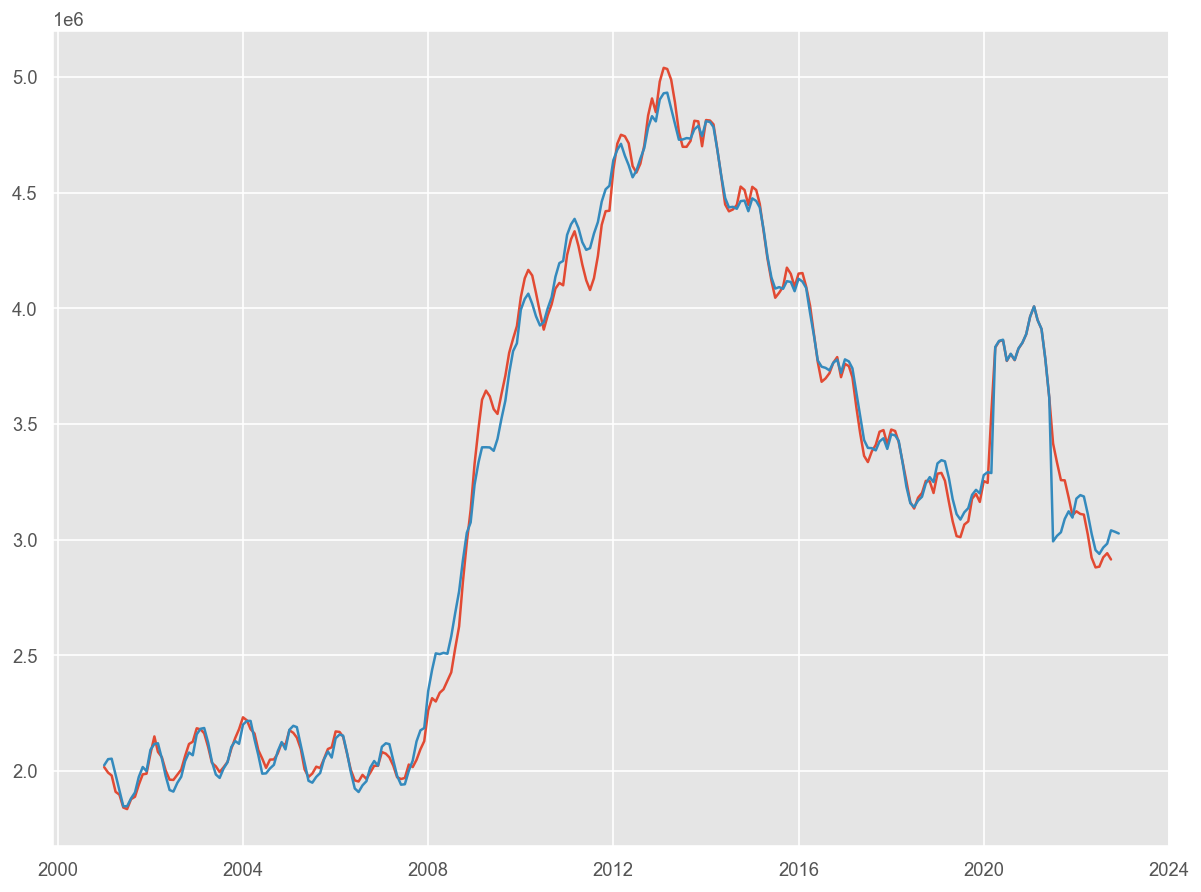

In [209]:
#Obtain forecasts for in-sample and out-of-sample
start = 0
horizon = 1
end = df_unemployment.shape[0] + horizon

yhat = forecast2.loc[(forecast2.index <= end) & (forecast2.index >= start)].yhat

initial_date = df_unemployment.index[start]

# Obtener las fechas de la prediccion (indice de fecha en nuestro df)
dates_to_plot = []
num_index = np.arange(start, end+1)
for i in range(0, len(num_index)):
    # Vamos añadiendo meses para pintar el indice de yhat
    d = df_unemployment.index[start] + pd.DateOffset(months=i)
    dates_to_plot.append(d)
yhat.index = dates_to_plot

plt.figure()

plt.plot(df_unemployment["TOTAL"].loc[initial_date:])
plt.plot(yhat)
plt.show()

In [211]:
yhat

2001-01-01    2.025297e+06
2001-02-01    2.051653e+06
2001-03-01    2.053641e+06
2001-04-01    1.984016e+06
2001-05-01    1.915472e+06
                  ...     
2022-08-01    2.966539e+06
2022-09-01    2.983315e+06
2022-10-01    3.040791e+06
2022-11-01    3.034640e+06
2022-12-01    3.027302e+06
Name: yhat, Length: 264, dtype: float64

In [213]:
#Error MAE - Mean Absolute error
print('MAE:',mean_absolute_error(df_unemployment['TOTAL'], yhat[:-2]))
#Error RMSE - Root Mean Square Error
print('RMSE:',math.sqrt(mean_squared_error(df_unemployment['TOTAL'], yhat[:-2])))
#Error r^2 
print('R2:',r2_score(df_unemployment['TOTAL'], yhat[:-2]))

MAE: 51148.53319202079
RMSE: 76170.05661524988
R2: 0.9940209067737331
